## Result Visualization Scripts


In [395]:
import pandas as pd
import numpy as np
import glob
import os
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import re
import matplotlib.font_manager as fm

font_path = '/usr/share/fonts/truetype/msttcorefonts/times.ttf'
font_prop = fm.FontProperties(fname=font_path)

plt.rcParams['font.family'] = font_prop.get_name()

print("Font loaded:", font_prop.get_name())


Font loaded: Times New Roman


In [21]:
RESULTS_FOLDER = "../results_csv/"
FIGURE_FOLDER = "../figures/"
TABLE_FOLDER = "../tables/"

os.makedirs(FIGURE_FOLDER, exist_ok=True)
os.makedirs(TABLE_FOLDER, exist_ok=True)

In [131]:
def read_csv_file(filepath):
    try:
        df = pd.read_csv(filepath)
        print(f"Loaded: {filepath}")
        return df
    except Exception as e:
        print(f"Error reading {filepath}: {e}")
        return None

In [132]:
def parse_filename(filename):
    filename = filename.replace("_table.csv", "")
    parts = filename.split('_')
    
    task = None
    model_type = None
    metric = None
    split = None
    submetric = "complexity"
    layer = "overall"
    
    if "lm_probe" in filename:
        if parts[0] == "single" and parts[1] == "submetric":
            task = "single_submetric"
            model_type = "lm_probe"
            metric = parts[4]
            split = parts[5]
            
            if "layer" in filename:
                layer_parts = [p for p in parts if p.startswith("layer")]
                layer = layer_parts[0] if layer_parts else "overall"
                split_index = parts.index(split)
                layer_index = parts.index(layer)
                submetric = "_".join(parts[split_index+1:layer_index])
            else:
                split_index = parts.index(split)
                submetric = "_".join(parts[split_index+1:])
        
        elif parts[0] == "complexity":
            task = "complexity"
            model_type = "lm_probe"
            metric = parts[3]
            split = parts[4]
            
            if "layer" in filename:
                layer_parts = [p for p in parts if p.startswith("layer")]
                layer = layer_parts[0] if layer_parts else "overall"
                split_index = parts.index(split)
                layer_index = parts.index(layer)
                if split_index + 1 < layer_index:
                    submetric = "_".join(parts[split_index+1:layer_index])
            else:
                split_index = parts.index(split)
                if len(parts) > split_index + 1:
                    submetric = "_".join(parts[split_index+1:])
        
        elif parts[0] == "question" and parts[1] == "type":
            task = "question_type"
            model_type = "lm_probe"
            metric = parts[4]
            split = parts[5]
            
            if "layer" in filename:
                layer_parts = [p for p in parts if p.startswith("layer")]
                layer = layer_parts[0] if layer_parts else "overall"
                
                split_index = parts.index(split)
                layer_index = parts.index(layer)
                if split_index + 1 < layer_index:
                    submetric = "_".join(parts[split_index+1:layer_index])
                else:
                    submetric = "overall"
            else:
                split_index = parts.index(split)
                if len(parts) > split_index + 1:
                    submetric = "_".join(parts[split_index+1:])
                else:
                    submetric = "overall"
    
    elif parts[0] == "complexity":
        model_type = parts[1]
        metric = parts[2]
        split = parts[3]
        
        if len(parts) > 4:
            known_submetrics = ["avg_links_len", "avg_max_depth", "avg_subordinate_chain_len", "avg_verb_edges", "lexical_density", "n_tokens"]
            
            potential_submetric = "_".join(parts[4:])
            
            is_submetric = False
            for sm in known_submetrics:
                sm_parts = sm.split("_")
                if potential_submetric == sm or all(p in parts[4:] for p in sm_parts):
                    is_submetric = True
                    submetric = sm
                    break
            
            if is_submetric:
                task = "single_submetric"
            else:
                task = "complexity"
                submetric = potential_submetric
        else:
            task = "complexity"
            submetric = "complexity"
    
    elif parts[0] == "question" and parts[1] == "type":
        task = "question_type"
        model_type = parts[2]
        metric = parts[3]
        split = parts[4]
        
        if len(parts) > 5:
            submetric = "_".join(parts[5:])
        else:
            submetric = "overall"
    
    else:
        raise ValueError(f"Unknown filename format: {filename}")
    
    return {"task": task,"model_type": model_type,"metric": metric,"split": split,"submetric": submetric,"layer": layer}

In [133]:
def compute_selectivity(df, metric_type):
    
    df['control_mean'] = df[['control1', 'control2', 'control3']].mean(axis=1)
    if metric_type == "classification":
        df['selectivity'] = df['real'] - df['control_mean']
        epsilon = 1e-10
        adjusted_control = df['control_mean'].copy()
        adjusted_control[adjusted_control == 0] = epsilon
        df['normalized_selectivity'] = (df['selectivity'] / adjusted_control) * 100

    elif metric_type == "regression":
        df['selectivity'] = df['control_mean'] - df['real']
        epsilon = 1e-10
        adjusted_control = df['control_mean'].copy()
        adjusted_control[adjusted_control == 0] = epsilon
        df['normalized_selectivity'] = (df['selectivity'] / adjusted_control) * 100
    else:
        raise ValueError(f"Unknown metric type: {metric_type}")
    return df

def detect_metric_type(metric_name):
    name = metric_name.lower()
    if "accuracy" in name:
        return "classification"
    elif "mse" in name:
        return "regression"
    else:
        raise ValueError(f"Cannot infer metric type from: {metric_name}")


all_results = []

for filepath in glob.glob(os.path.join(RESULTS_FOLDER, "*.csv")):
    filename = os.path.basename(filepath)
    meta = parse_filename(filename)
    
    df = read_csv_file(filepath)
    if df is None:
        continue
    
    metric_type = detect_metric_type(meta['metric'])
    df = compute_selectivity(df, metric_type)
    
    for key, value in meta.items():
        df[key] = value
    
    all_results.append(df)

results_df = pd.concat(all_results, ignore_index=True)
print(f"\nLoaded {len(results_df)} results.")




Loaded: ../results_csv/single_submetric_lm_probe_mse_test_avg_max_depth_layer11_table.csv
Loaded: ../results_csv/complexity_DummyRegressor_mse_test_avg_max_depth_table.csv
Loaded: ../results_csv/complexity_lm_probe_mse_test_complexity_layer6_table.csv
Loaded: ../results_csv/complexity_XGBRegressor_mse_test_avg_links_len_table.csv
Loaded: ../results_csv/single_submetric_lm_probe_mse_test_avg_verb_edges_layer11_table.csv
Loaded: ../results_csv/question_type_DummyClassifier_accuracy_test_table.csv
Loaded: ../results_csv/question_type_lm_probe_accuracy_test_overall_layer2_table.csv
Loaded: ../results_csv/single_submetric_lm_probe_mse_test_lexical_density_layer2_table.csv
Loaded: ../results_csv/complexity_Ridge_mse_test_avg_max_depth_table.csv
Loaded: ../results_csv/complexity_DummyRegressor_mse_test_table.csv
Loaded: ../results_csv/single_submetric_lm_probe_mse_test_avg_links_len_layer12_table.csv
Loaded: ../results_csv/complexity_XGBRegressor_mse_val_avg_max_depth_table.csv
Loaded: ../res

In [349]:
pd.set_option('display.max_rows', 500) 
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
display(results_df)

,language,real,control1,control2,control3,control_mean,selectivity,normalized_selectivity,task,model_type,metric,split,submetric,layer,layer_num
0,ar,0.033268,0.056912,0.052436,0.054157,0.054501,2.123378e-02,3.896009e+01,single_submetric,lm_probe,mse,test,avg_max_depth,layer11,11
1,en,0.010210,0.029157,0.028907,0.030159,0.029408,1.919792e-02,6.528137e+01,single_submetric,lm_probe,mse,test,avg_max_depth,layer11,11
2,fi,0.014373,0.033075,0.032091,0.028904,0.031356,1.698298e-02,5.416106e+01,single_submetric,lm_probe,mse,test,avg_max_depth,layer11,11
3,id,0.024705,0.033570,0.035444,0.036486,0.035167,1.046116e-02,2.974743e+01,single_submetric,lm_probe,mse,test,avg_max_depth,layer11,11
4,ja,0.028016,0.080426,0.084185,0.077391,0.080667,5.265128e-02,6.526956e+01,single_submetric,lm_probe,mse,test,avg_max_depth,layer11,11
5,ko,0.013125,0.036801,0.036801,0.035986,0.036529,2.340406e-02,6.406918e+01,single_submetric,lm_probe,mse,test,avg_max_depth,layer11,11
6,ru,0.012541,0.023902,0.024423,0.023297,0.023874,1.133251e-02,4.746819e+01,single_submetric,lm_probe,mse,test,avg_max_depth,layer11,11
7,ar,0.052279,0.052279,0.052279,0.052279,0.052279,0.000000e+00,0.000000e+00,single_submetric,DummyRegressor,mse,test,avg_max_depth,overall,0
8,en,0.028999,0.028999,0.028999,0.028999,0.028999,3.469447e-18,1.196421e-14,single_submetric,DummyRegressor,mse,test,avg_max_depth,overall,0
9,fi,0.035270,0.035270,0.035270,0.035270,0.035270,0.000000e+00,0.000000e+00,single_submetric,DummyRegressor,mse,test,avg_max_depth,overall,0


In [208]:
def plot_real_vs_selectivity(df, task, split="test", submetric="overall",models=None, normalize_selectivity=True,languages=None, figsize=(24, 8), show_layers=True):
    
    data = df[(df["task"] == task) & (df["split"] == split) & (df["submetric"] == submetric)]

    if models is not None:
        data = data[data["model_type"].isin(models)]

    if languages is not None:
        data = data[data["language"].isin(languages)]

    if data.empty:
        print(f"No data for {task} / {submetric}")
        return

    def format_label(row):
        if "lm_probe" in row["model_type"] and show_layers:
            return f"LM {row['layer'].replace('layer', 'L')}"
        else:
            return row["model_type"]

    data = data.copy()
    data["model_label"] = data.apply(format_label, axis=1)

    right_y = "normalized_selectivity" if normalize_selectivity else "selectivity"


    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)

    palette = sns.color_palette("colorblind", n_colors=len(data["model_label"].unique()))

    sns.barplot(x="language", y="real", hue="model_label", data=data, ax=ax1, palette=palette)
    sns.barplot(x="language", y=right_y, hue="model_label", data=data, ax=ax2, palette=palette)

    task_title = {
        "complexity": "Complexity Prediction",
        "question_type": "Question Type Classification",
        "single_submetric": f"Submetric: {submetric}"
    }.get(task, task)

    fig.suptitle(f"{task_title} ({split} set)", fontsize=20)

    ax1.set_title("Real Performance", fontsize=16)
    ax1.set_ylabel("Accuracy" if task == "question_type" else "MSE")
    ax1.set_xlabel("Language")
    ax1.tick_params(axis='x', rotation=45)
    ax1.grid(axis='y', linestyle='--', alpha=0.7)

    ax2.set_title("Normalized Selectivity" if normalize_selectivity else "Selectivity", fontsize=16)
    ax2.set_ylabel("Selectivity" if not normalize_selectivity else "Normalized Selectivity")
    ax2.set_xlabel("Language")
    ax2.tick_params(axis='x', rotation=45)
    ax2.grid(axis='y', linestyle='--', alpha=0.7)

    handles, labels = ax2.get_legend_handles_labels()
    ax1.get_legend().remove()
    ax2.legend(handles, labels, title="Model", bbox_to_anchor=(1.05, 1), loc="upper left")

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


In [210]:
def plot_lm_layer_evolution(df, task, split="test", submetric="overall",languages=None, normalize_selectivity=False, figsize=(12, 8)):

    data = df[(df["task"] == task) & (df["split"] == split) & (df["submetric"] == submetric) & (df["model_type"] == "lm_probe")]

    if languages is not None:
        data = data[data["language"].isin(languages)]

    if data.empty:
        print(f"No LM probe data for {task} / {submetric}")
        return

    layer_order = ["layer2", "layer6", "layer11", "layer12"]
    data["layer"] = pd.Categorical(data["layer"], categories=layer_order, ordered=True)

    y_metric = "normalized_selectivity" if normalize_selectivity else "selectivity"

    plt.figure(figsize=figsize)
    sns.lineplot(data=data,x="layer",y=y_metric,hue="language",marker="o")

    plt.title(f"Layer-wise {'Normalized ' if normalize_selectivity else ''}Selectivity - {task} ({submetric})", fontsize=16)
    plt.ylabel("Normalized Selectivity" if normalize_selectivity else "Selectivity")
    plt.xlabel("Layer")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend(title="Language", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()


In [212]:
def plot_submetric_heatmap(df, task="single_submetric", split="test", model="lm_probe", layer="layer12",normalize_selectivity=False, figsize=(16, 10)):

    data = df[(df["task"] == task) &(df["split"] == split) & (df["model_type"] == model) & (df["layer"] == layer)]

    if data.empty:
        print(f"No data for {task} / {model} / {layer}")
        return

    value_col = "normalized_selectivity" if normalize_selectivity else "selectivity"

    pivot = data.pivot_table(index="submetric", columns="language", values=value_col)

    plt.figure(figsize=figsize)
    sns.heatmap(
        pivot,
        annot=True,
        fmt=".2f",
        cmap="YlGnBu",
        cbar_kws={"label": "Normalized Selectivity" if normalize_selectivity else "Selectivity"}
    )
    
    plt.title(f"Submetric {'Normalized ' if normalize_selectivity else ''}Selectivity Heatmap ({model}, {layer})", fontsize=18)
    plt.xlabel("Language")
    plt.ylabel("Submetric")
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()


### Running the visuals

#### 1 Question Type Classification

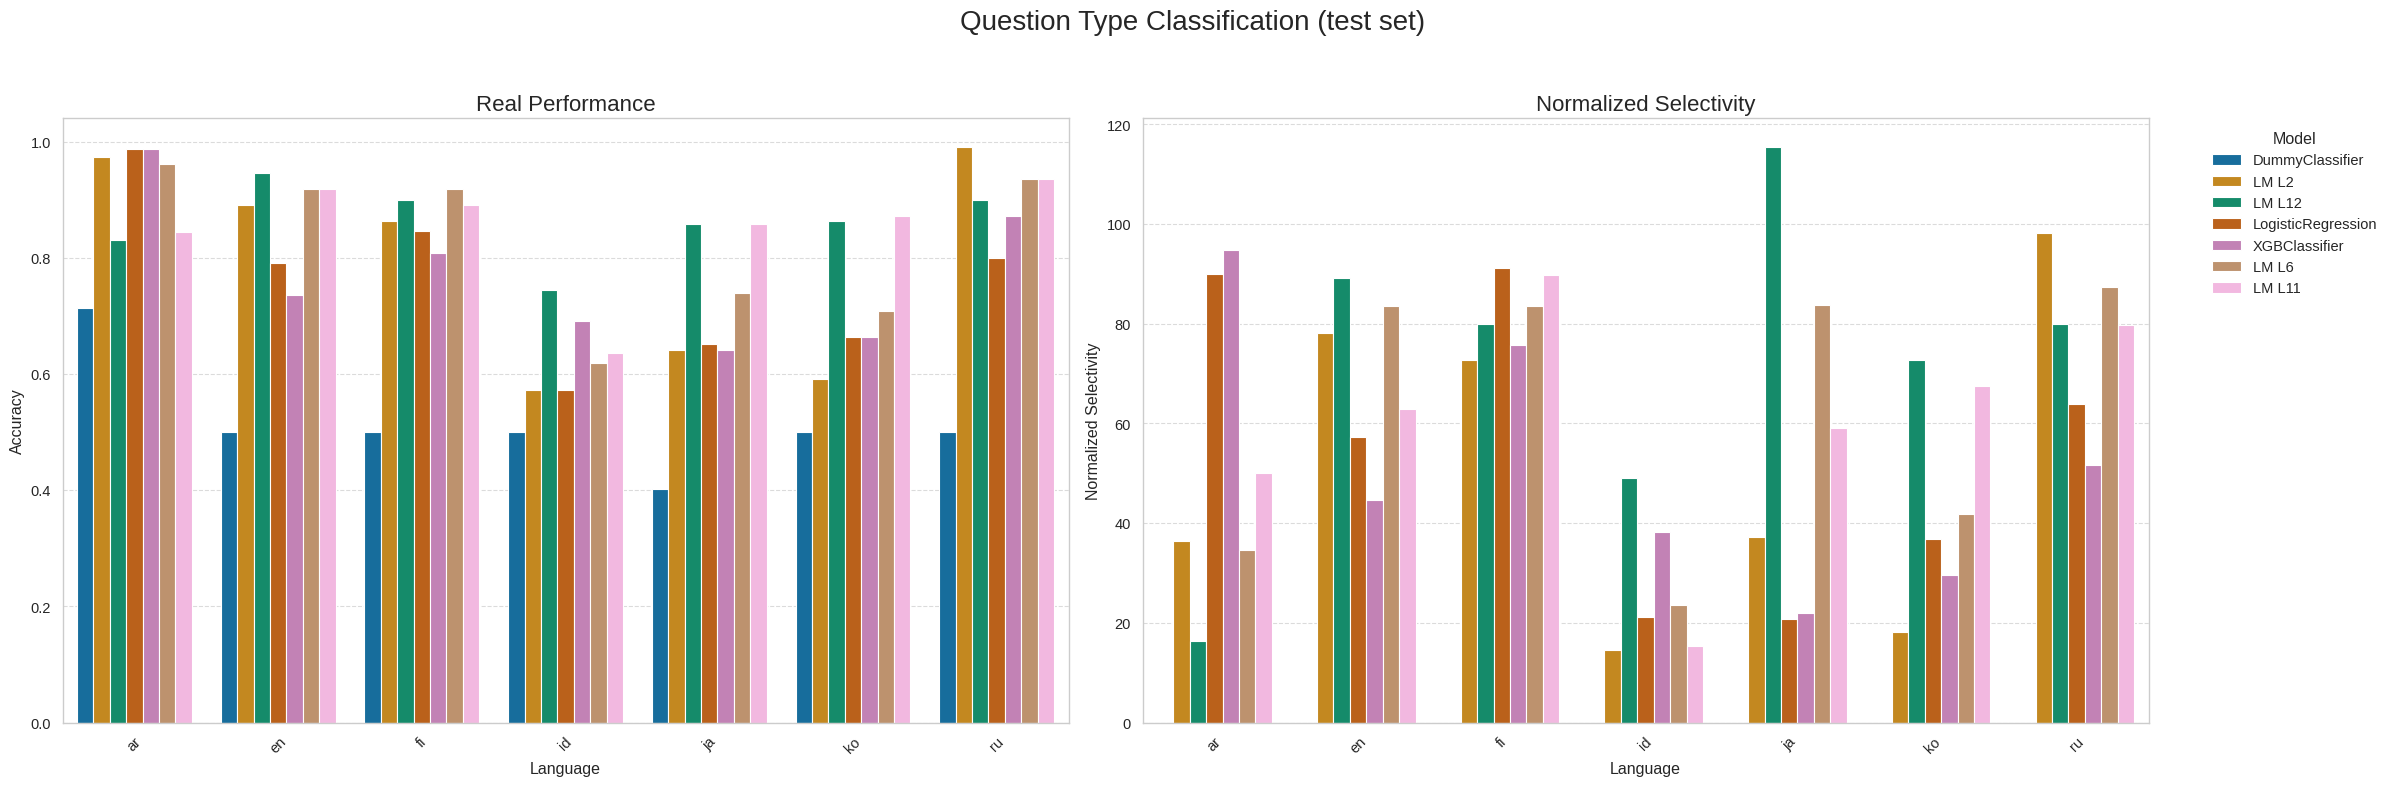

In [214]:
plot_real_vs_selectivity(
    results_df,
    task="question_type",
    split="test",
    submetric="overall",
    models=["DummyClassifier", "LogisticRegression", "XGBClassifier", "lm_probe"],
    normalize_selectivity=True, 
    show_layers=True
)


/tmp/ipykernel_1109400/3792833152.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["layer"] = pd.Categorical(data["layer"], categories=layer_order, ordered=True)


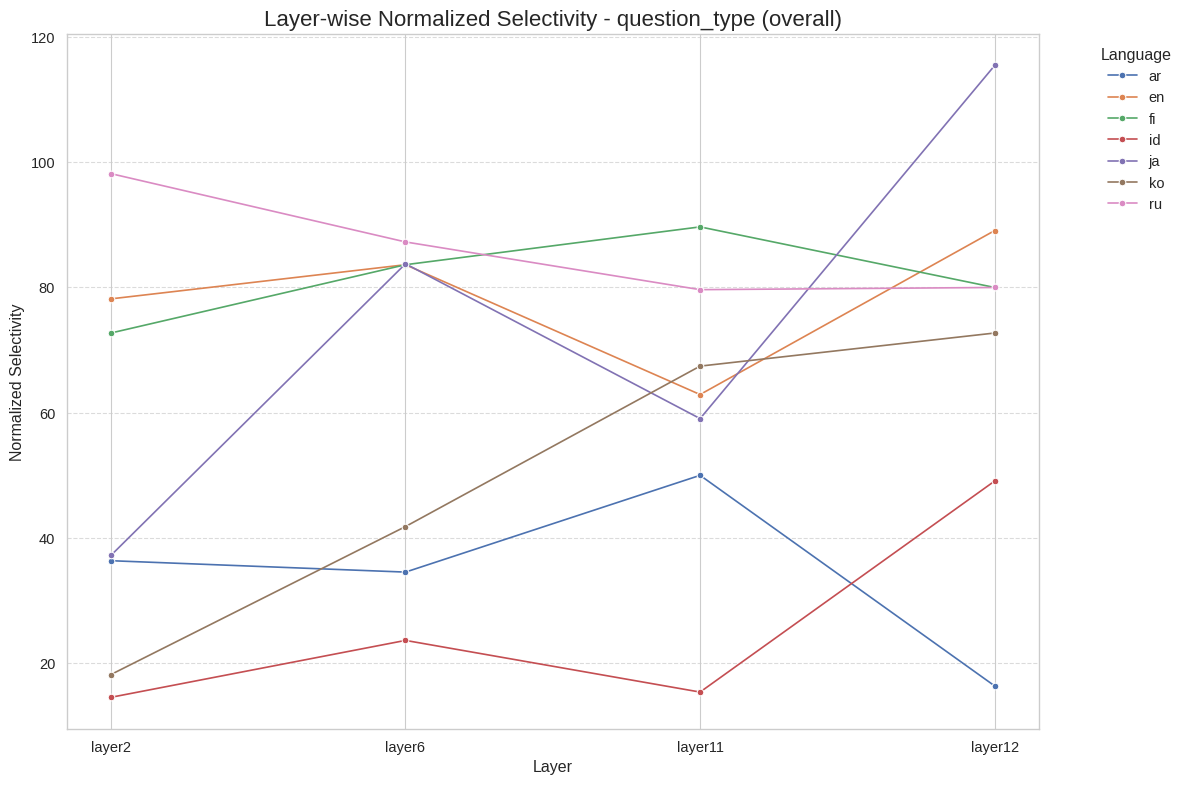

In [224]:
plot_lm_layer_evolution(results_df,task="question_type",split="test",submetric="overall",normalize_selectivity=True)

#### 2 Complexity Regression

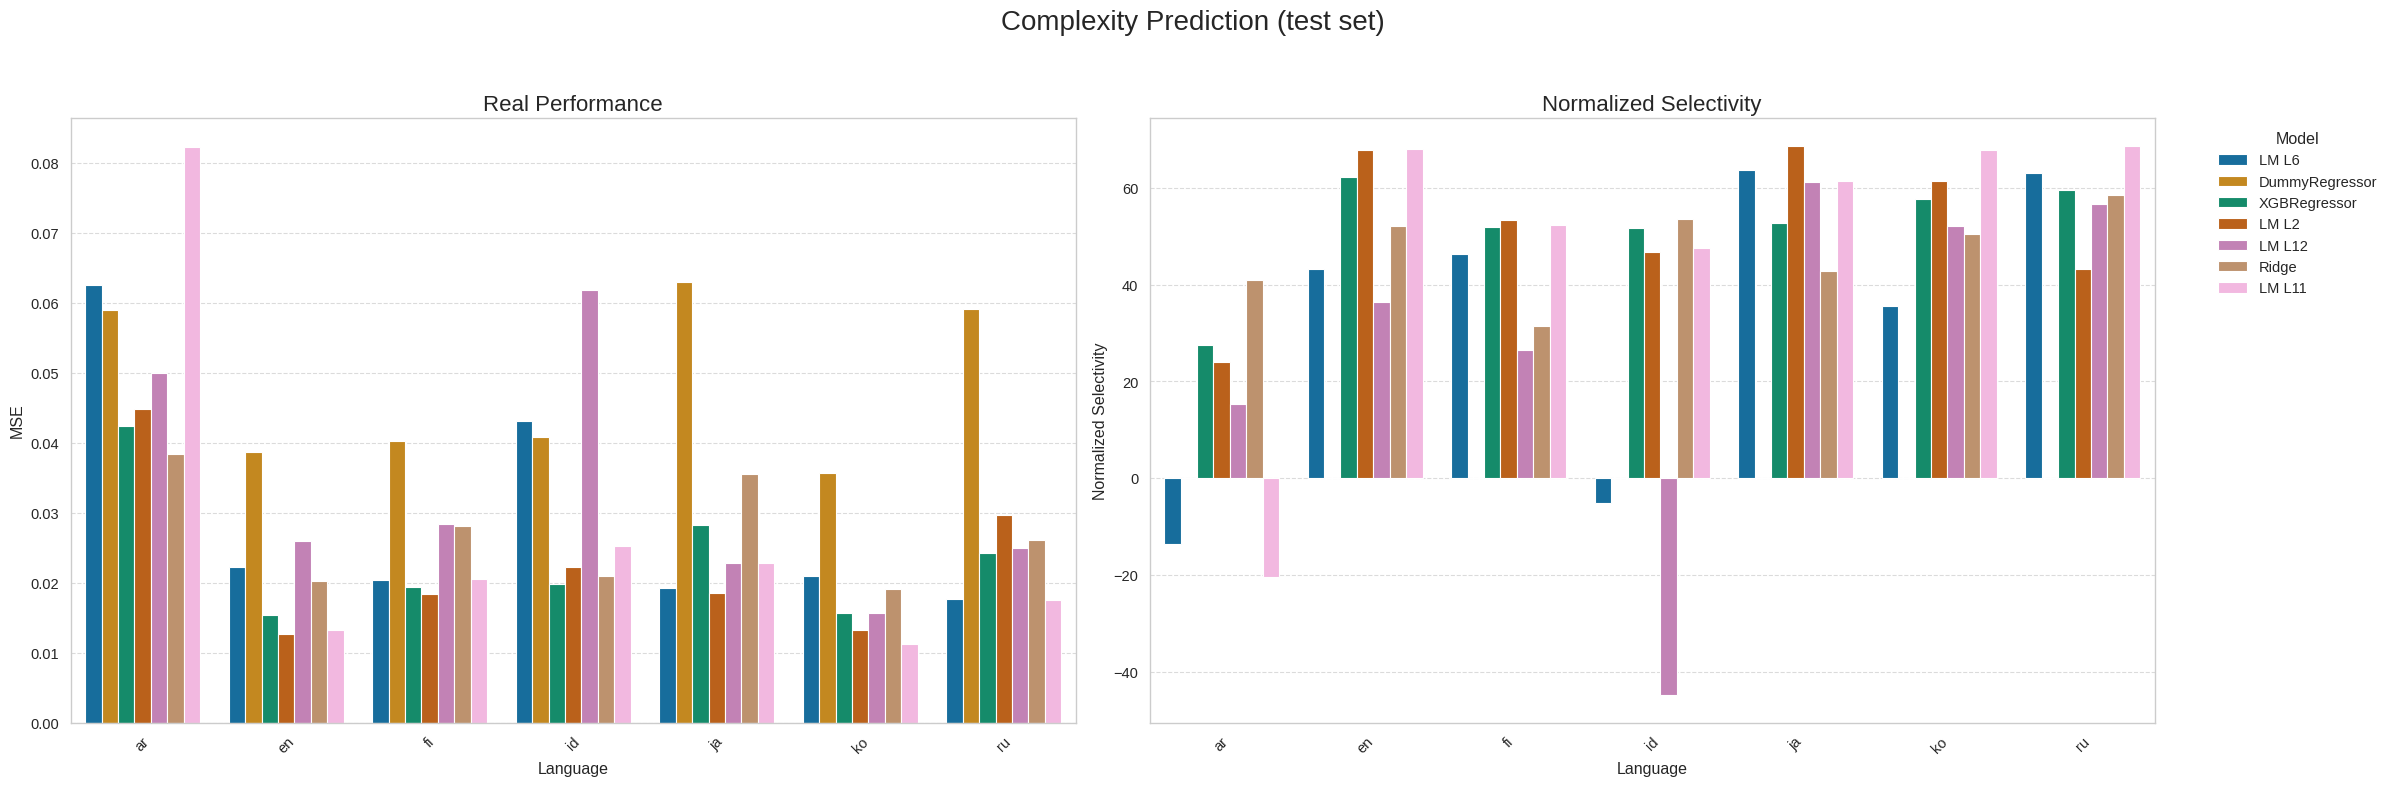

In [ ]:
plot_real_vs_selectivity(results_df,task="complexity",split="test",submetric="complexity",models=["DummyRegressor", "Ridge", "XGBRegressor", "lm_probe"],normalize_selectivity=True)

/tmp/ipykernel_1109400/3792833152.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["layer"] = pd.Categorical(data["layer"], categories=layer_order, ordered=True)


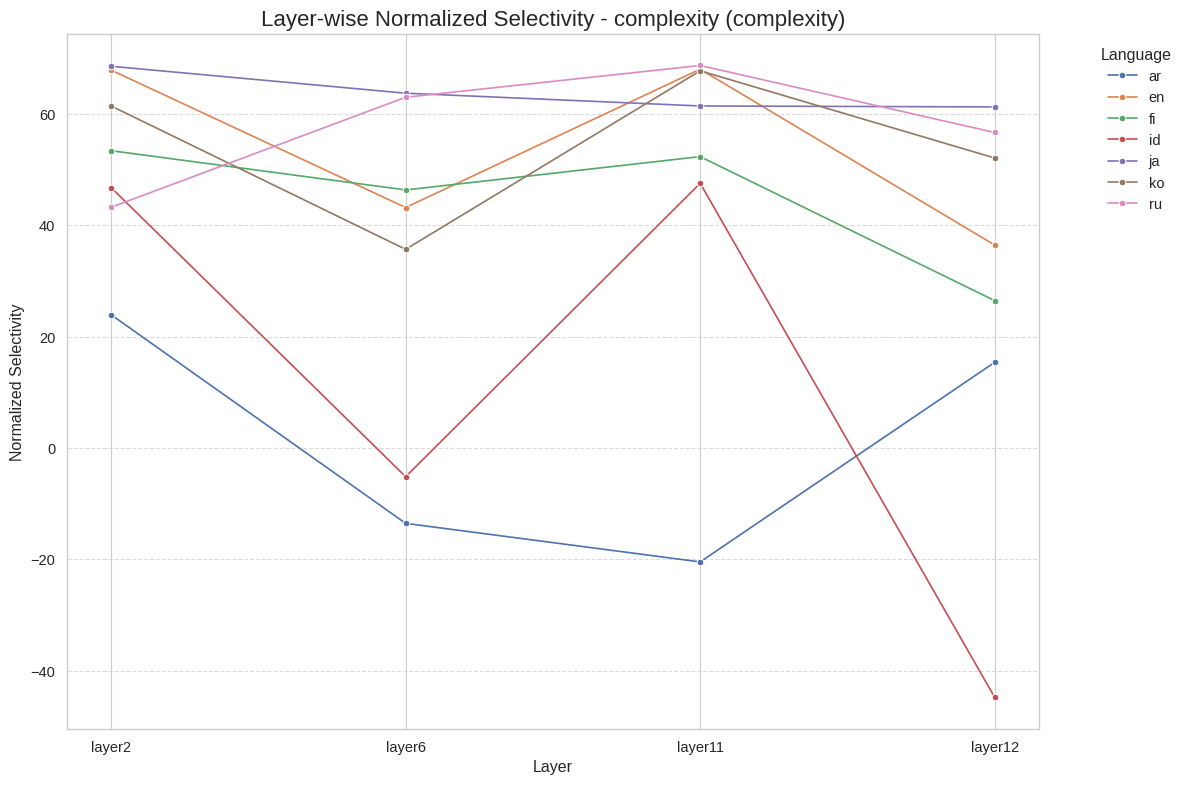

In [225]:
plot_lm_layer_evolution(results_df,task="complexity",split="test",submetric="complexity",normalize_selectivity=True)

#### 3 Complexity Submetric Regression

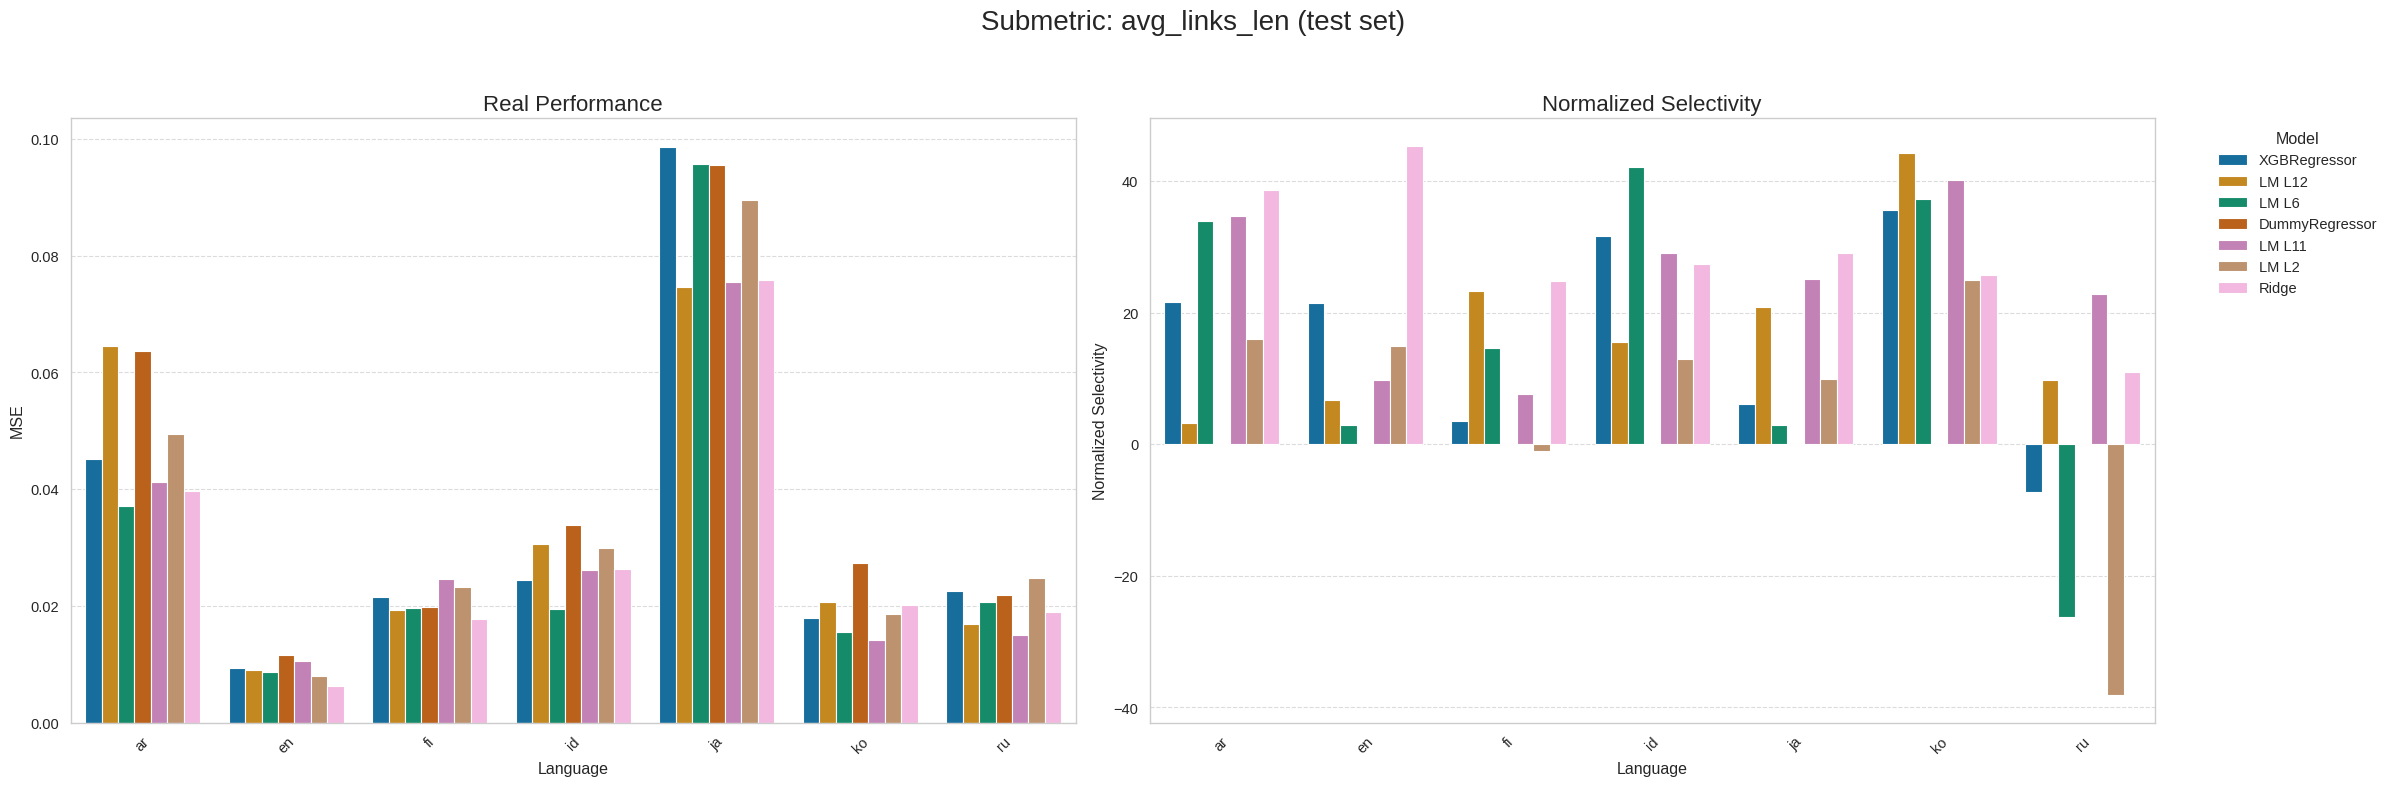

In [227]:
plot_real_vs_selectivity(results_df,task="single_submetric",split="test",submetric="avg_links_len",models=["DummyRegressor", "Ridge", "XGBRegressor", "lm_probe"],normalize_selectivity=True)

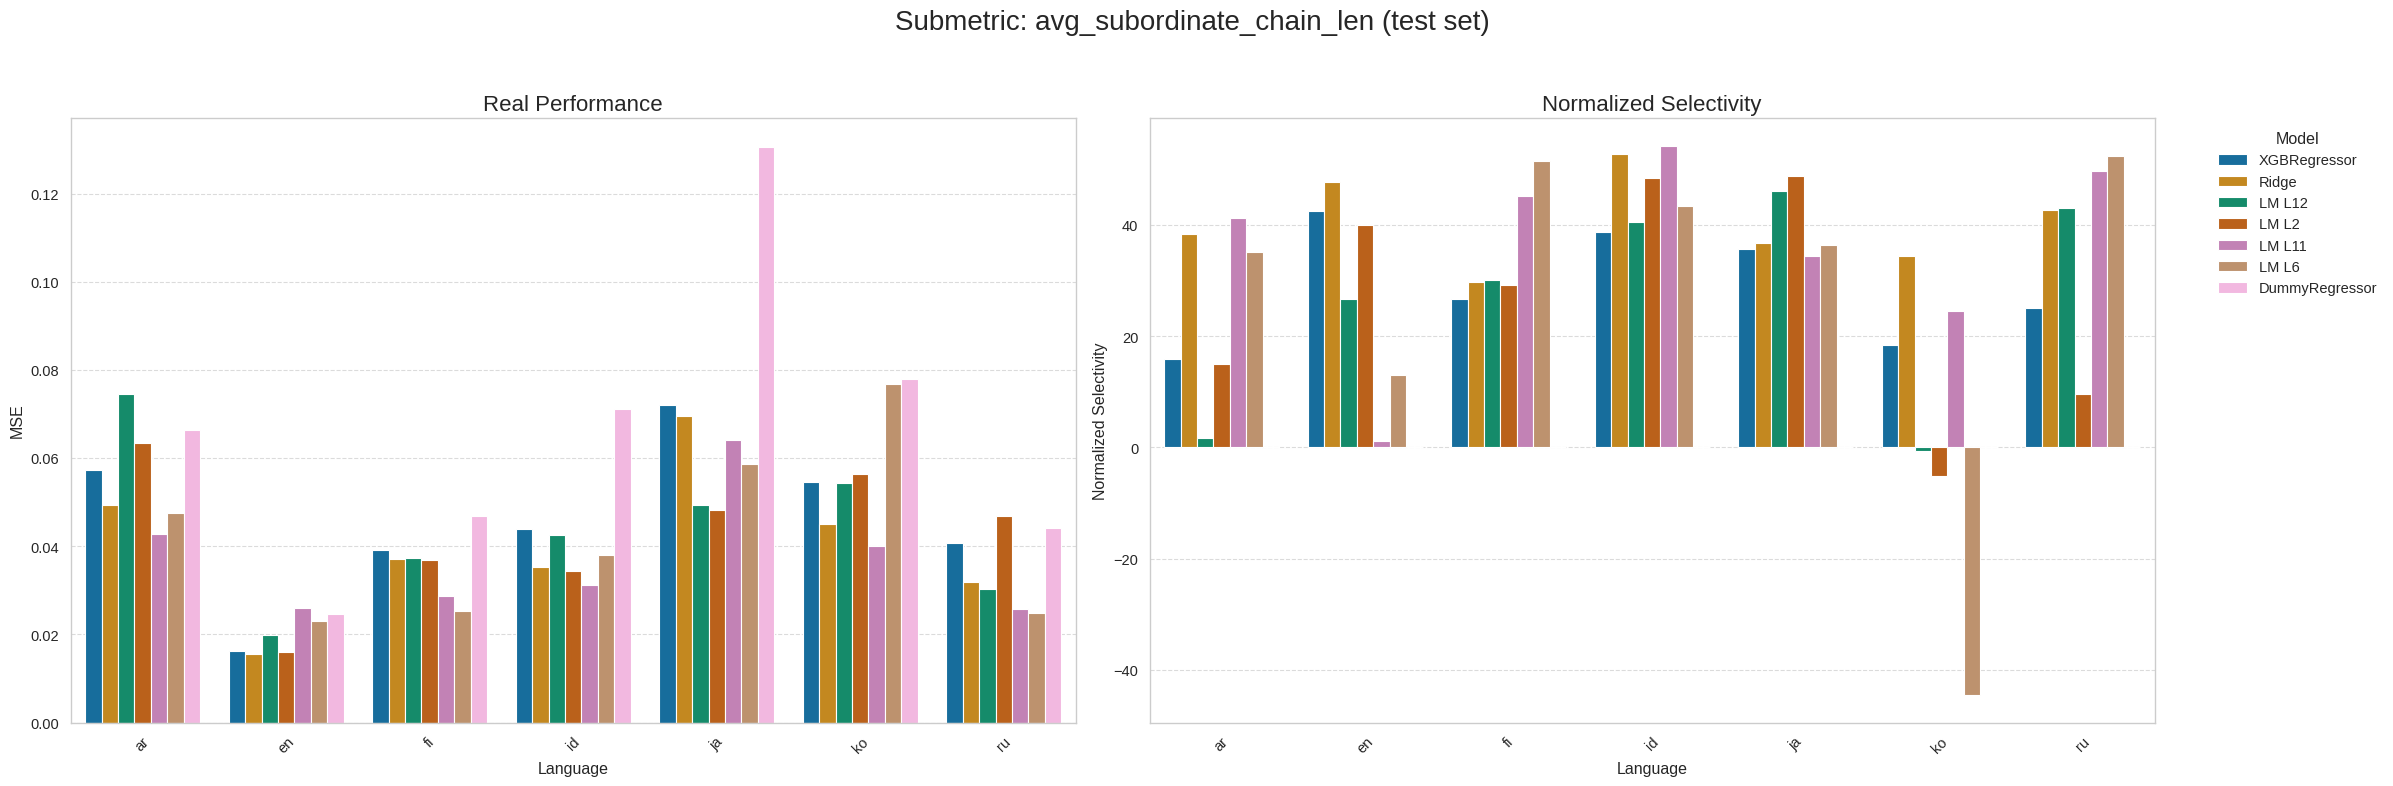

In [229]:
plot_real_vs_selectivity(results_df,task="single_submetric",split="test",submetric="avg_subordinate_chain_len",models=["DummyRegressor", "Ridge", "XGBRegressor", "lm_probe"],normalize_selectivity=True)

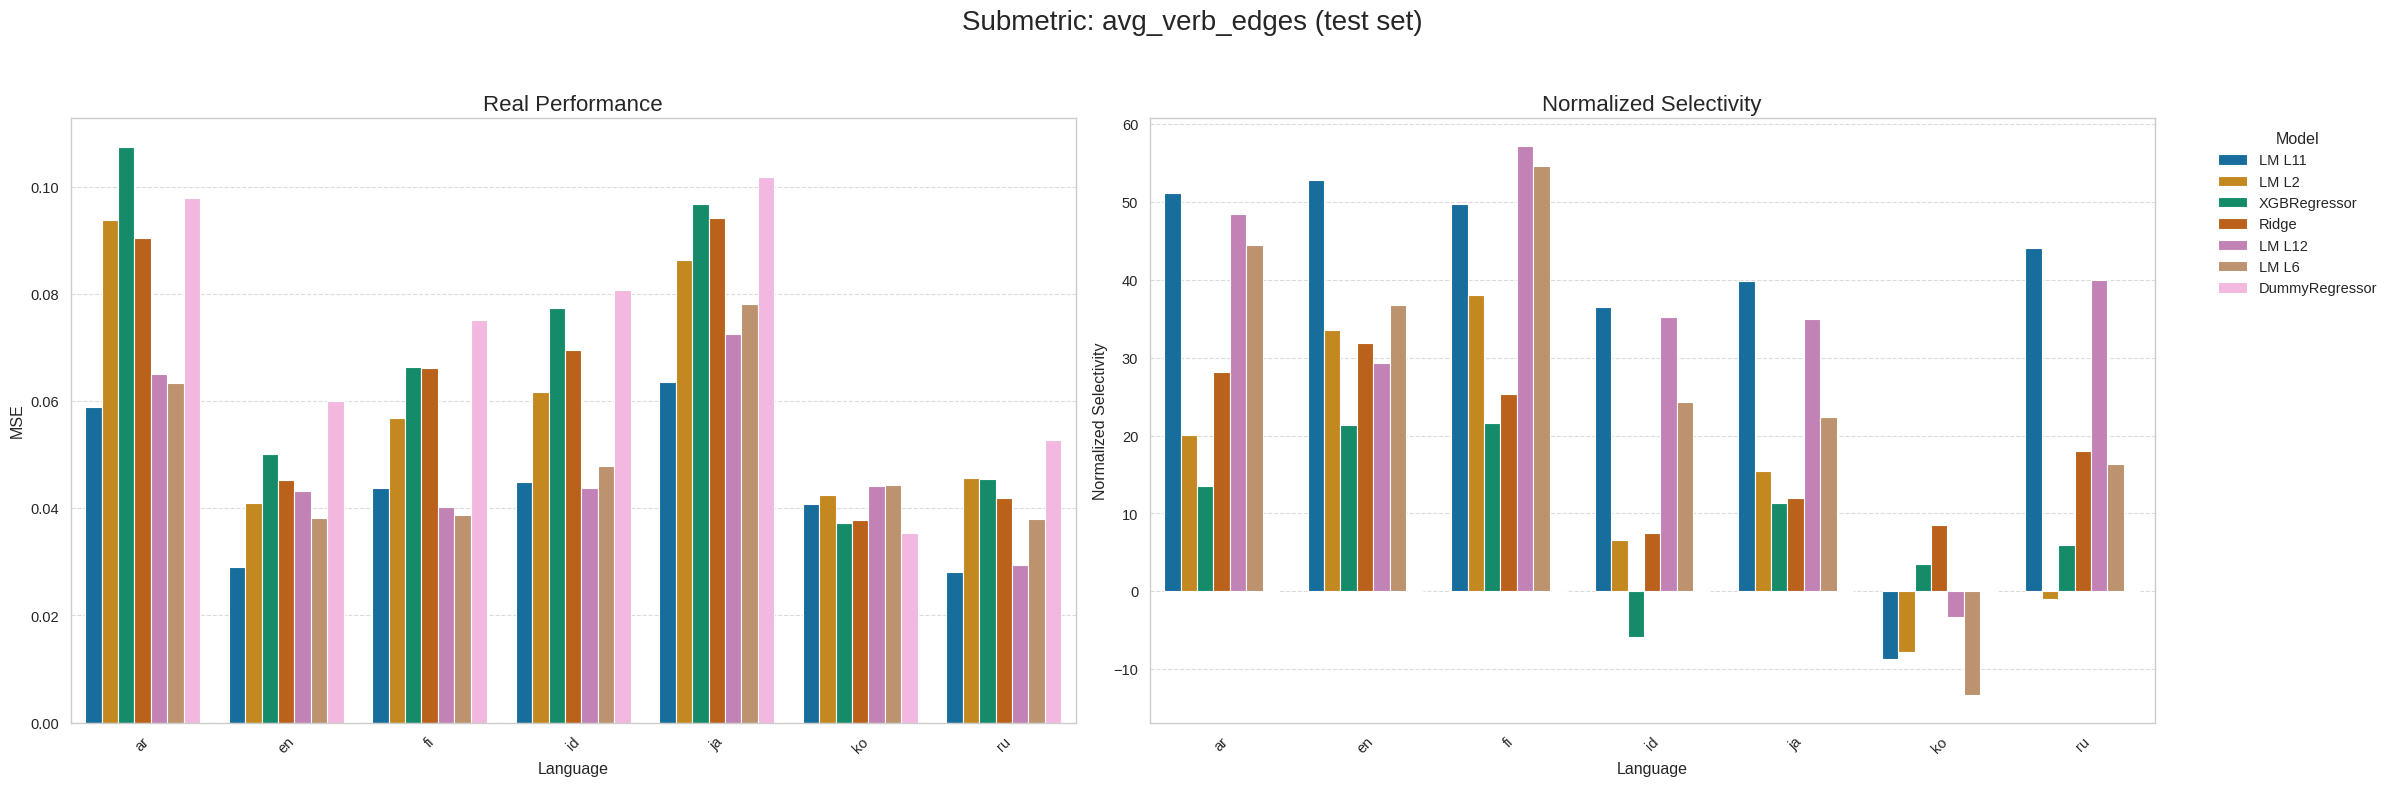

In [230]:
plot_real_vs_selectivity(results_df,task="single_submetric",split="test",submetric="avg_verb_edges",models=["DummyRegressor", "Ridge", "XGBRegressor", "lm_probe"],normalize_selectivity=True)

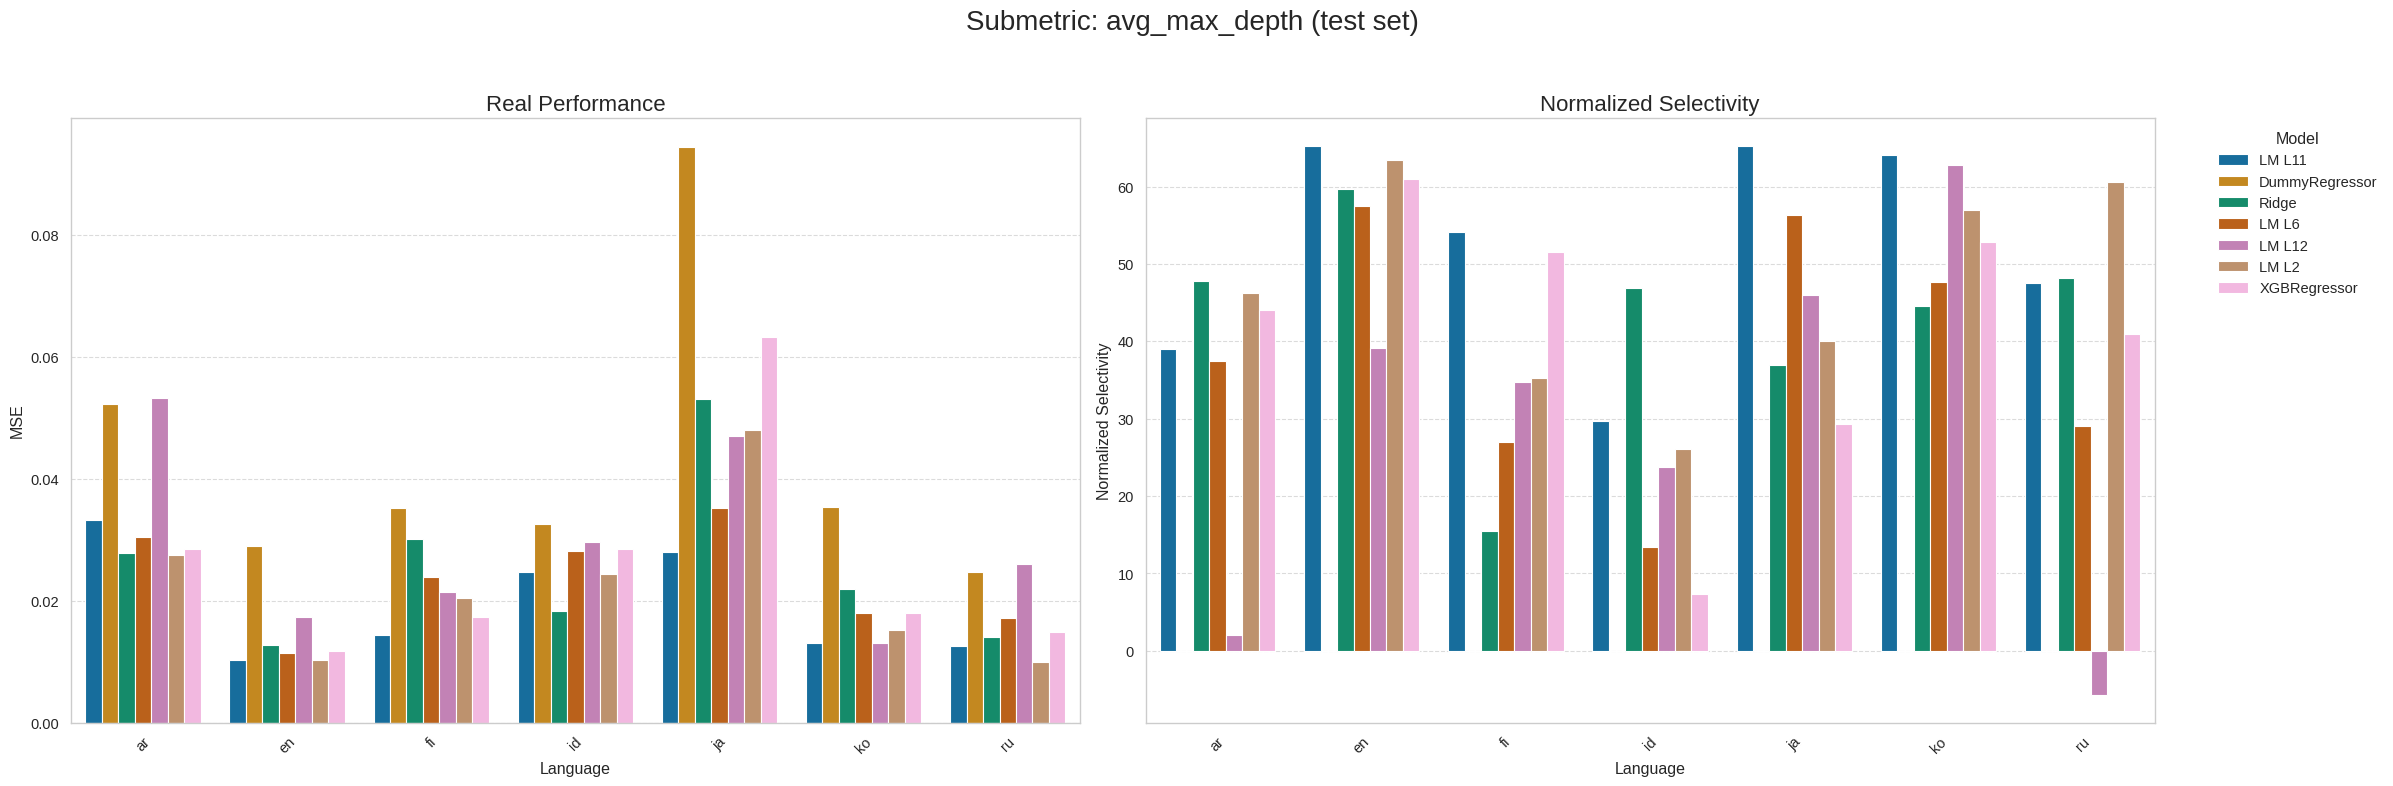

In [231]:
plot_real_vs_selectivity(results_df,task="single_submetric",split="test",submetric="avg_max_depth",models=["DummyRegressor", "Ridge", "XGBRegressor", "lm_probe"],normalize_selectivity=True)

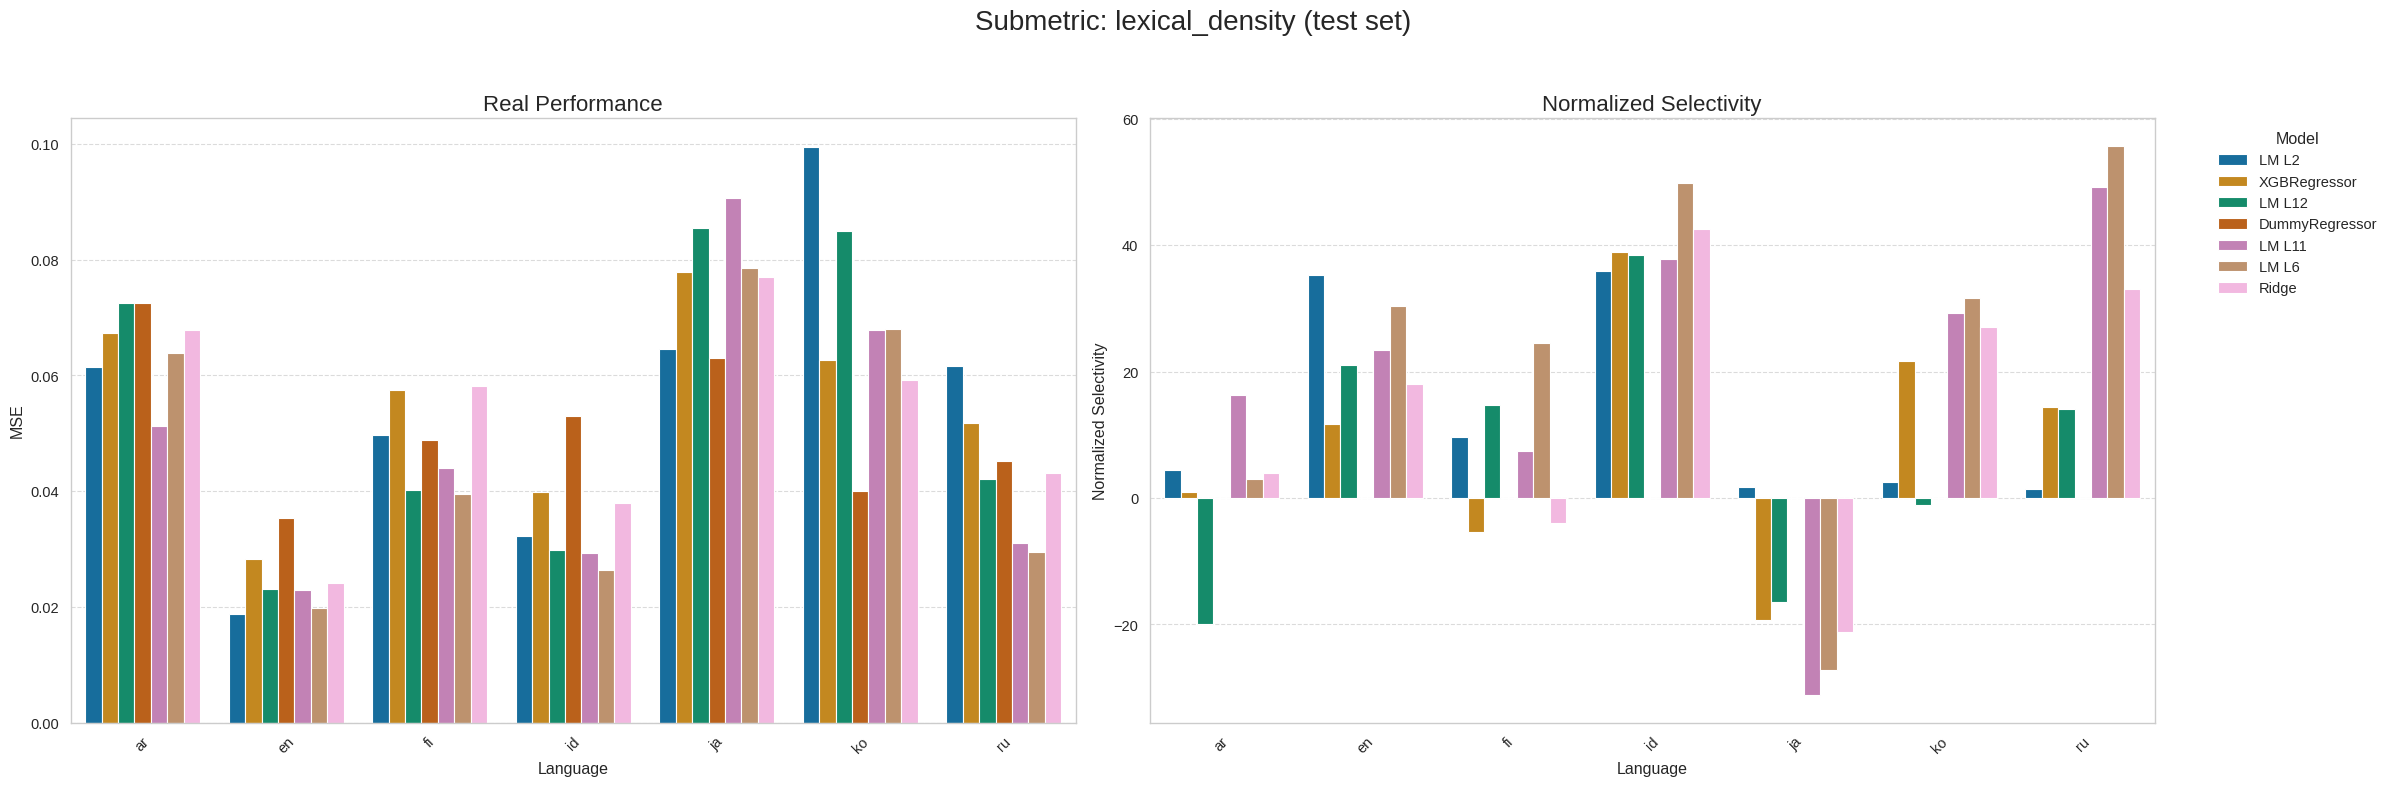

In [232]:
plot_real_vs_selectivity(results_df,task="single_submetric",split="test",submetric="lexical_density",models=["DummyRegressor", "Ridge", "XGBRegressor", "lm_probe"],normalize_selectivity=True)

In [258]:
def plot_task_comparison(df, task, split="test", submetric="overall", models=None,languages=None, normalize_selectivity=True, show_layers=True):
    plt.rcParams.update({
        'font.family': 'serif',
        'font.serif': ['Times New Roman', 'DejaVu Serif', 'Palatino', 'serif'],
        'font.size': 11,
        'axes.titlesize': 12,
        'axes.labelsize': 11,
        'xtick.labelsize': 10,
        'ytick.labelsize': 10,
        'legend.fontsize': 10
    })
    sns.set_theme(style="ticks", context="paper")
    
    fig = plt.figure(figsize=(7.2, 5.4))
    gs = fig.add_gridspec(2, 2, width_ratios=[1.2, 1], height_ratios=[1, 1], wspace=0.25, hspace=0.3)
    
    ax1 = fig.add_subplot(gs[0, 0])  # Real performance (larger)
    ax2 = fig.add_subplot(gs[1, 0])  # Normalized selectivity (larger)
    ax3 = fig.add_subplot(gs[:, 1])  # Layer evolution (full right column)
    
    data = df[(df["task"] == task) & (df["split"] == split) & (df["submetric"] == submetric)]
    if models is not None:
        data = data[data["model_type"].isin(models)]
    if languages is not None:
        data = data[data["language"].isin(languages)]
    
    data = data.copy()
    data["model_label"] = data.apply(lambda row: f"LM L{row['layer'].replace('layer', '')}" if "lm_probe" in row["model_type"] and show_layers else row["model_type"], axis=1)
    
    palette = sns.color_palette("Set2", n_colors=len(data["model_label"].unique()))
    
    y_metric = "real"
    sns.barplot(x="language", y=y_metric, hue="model_label", data=data, ax=ax1, palette=palette)
    ax1.set_title("Real Performance", fontsize=12, fontweight='bold')
    ax1.set_ylabel("Accuracy" if task == "question_type" else "MSE", fontsize=11)
    ax1.set_xlabel("") 
    ax1.tick_params(axis='x', rotation=45)
    ax1.grid(axis='y', linestyle='--', alpha=0.3)
    
    selectivity_metric = "normalized_selectivity" if normalize_selectivity else "selectivity"
    sns.barplot(x="language", y=selectivity_metric, hue="model_label", data=data, ax=ax2, palette=palette)
    ax2.set_title("Normalized Selectivity" if normalize_selectivity else "Selectivity", fontsize=12, fontweight='bold')
    ax2.set_ylabel("Selectivity Score", fontsize=11)
    ax2.set_xlabel("Language", fontsize=11)
    ax2.tick_params(axis='x', rotation=45)
    ax2.grid(axis='y', linestyle='--', alpha=0.3)
    
    lm_data = data[data["model_type"] == "lm_probe"].copy()
    if not lm_data.empty:
        layer_order = ["layer2", "layer6", "layer11", "layer12"]
        lm_data["layer"] = pd.Categorical(lm_data["layer"], categories=layer_order, ordered=True)
        
        sns.lineplot(data=lm_data, x="layer", y=selectivity_metric, hue="language", 
                   marker="o", markersize=8, linewidth=2, ax=ax3)
        
        ax3.set_title("Layer-wise Evolution", fontsize=12, fontweight='bold')
        ax3.set_ylabel("Selectivity Score", fontsize=11)
        ax3.set_xlabel("Layer", fontsize=11)
        ax3.grid(axis='both', linestyle='--', alpha=0.3)
    else:
        ax3.text(0.5, 0.5, "No layer data available", 
                ha='center', va='center', transform=ax3.transAxes)
    
    ax1.text(-0.08, 1.05, '(a)', transform=ax1.transAxes, fontsize=12, fontweight='bold')
    ax2.text(-0.08, 1.05, '(b)', transform=ax2.transAxes, fontsize=12, fontweight='bold')
    ax3.text(-0.08, 1.05, '(c)', transform=ax3.transAxes, fontsize=12, fontweight='bold')
    
    handles, labels = ax1.get_legend_handles_labels()
    [ax.get_legend().remove() for ax in [ax1, ax2, ax3]]
    fig.legend(handles, labels, title="Model", bbox_to_anchor=(0.5, 0), 
              loc="lower center", ncol=min(len(labels), 4), frameon=False)
    
    task_title = {
        "complexity": "Complexity Prediction",
        "question_type": "Question Type Classification",
        "single_submetric": f"Submetric: {submetric}"
    }.get(task, task)
    fig.suptitle(f"{task_title} ({split} set)", fontsize=14, fontweight='bold', y=0.98)
    
    plt.tight_layout(rect=[0, 0.08, 1, 0.95])
    return fig

In [259]:
def plot_submetric_grid(df, split="test", models=None, languages=None, normalize_selectivity=True):
    plt.rcParams.update({
        'font.family': 'serif',
        'font.serif': ['Times New Roman', 'DejaVu Serif', 'Palatino', 'serif'],
        'font.size': 11,
        'axes.titlesize': 12,
        'axes.labelsize': 11
    })
    sns.set_theme(style="ticks", context="paper")
    
    submetrics = ["avg_max_depth", "avg_links_len", "avg_subordinate_chain_len", "lexical_density", "n_tokens", "avg_verb_edges"]
    
    fig, axes = plt.subplots(2, 3, figsize=(7.2, 6), sharex=True)
    plt.subplots_adjust(wspace=0.25, hspace=0.3)
    axes = axes.flatten()
    
    palette = sns.color_palette("Set1", n_colors=7)
    
    for i, submetric in enumerate(submetrics):
        data = df[(df["task"] == "single_submetric") & 
                (df["split"] == split) & 
                (df["submetric"] == submetric)]
        
        if models is not None:
            data = data[data["model_type"].isin(models)]
        if languages is not None:
            data = data[data["language"].isin(languages)]
        
        data = data.copy()
        data["model_label"] = data.apply(lambda row: 
                                      f"LM L{row['layer'].replace('layer', '')}" 
                                      if "lm_probe" in row["model_type"] 
                                      else row["model_type"], axis=1)
        
        ax = axes[i]
        selectivity_metric = "normalized_selectivity" if normalize_selectivity else "selectivity"
        
        sns.barplot(x="language", y=selectivity_metric, hue="model_label", 
                  data=data, ax=ax, palette=palette)
        
        metric_name = submetric.replace('_', ' ').replace('avg ', '')
        ax.set_title(f"{metric_name}", fontsize=12, fontweight='bold')
        
        if i % 2 == 0:
            ax.set_ylabel("Selectivity Score", fontsize=11)
        else:
            ax.set_ylabel("")
        
        if i >= 2:
            ax.set_xlabel("Language", fontsize=11)
        else:
            ax.set_xlabel("")
            
        ax.tick_params(axis='x', rotation=45)
        ax.grid(axis='y', linestyle='--', alpha=0.3)
        
        # Add subplot label
        ax.text(-0.08, 1.05, f'({chr(97+i)})', transform=ax.transAxes, 
              fontsize=12, fontweight='bold')
        
        # Remove individual legends
        ax.get_legend().remove()
    
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, title="Model", bbox_to_anchor=(0.5, 0), 
              loc="lower center", ncol=min(len(labels), 4), frameon=False)
    
    fig.suptitle(f"Linguistic Submetric Analysis ({split} set)", 
                fontsize=14, fontweight='bold')
    plt.tight_layout(rect=[0, 0.08, 1, 0.95])
    return fig

/tmp/ipykernel_1109400/2805205168.py:99: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.08, 1, 0.95])


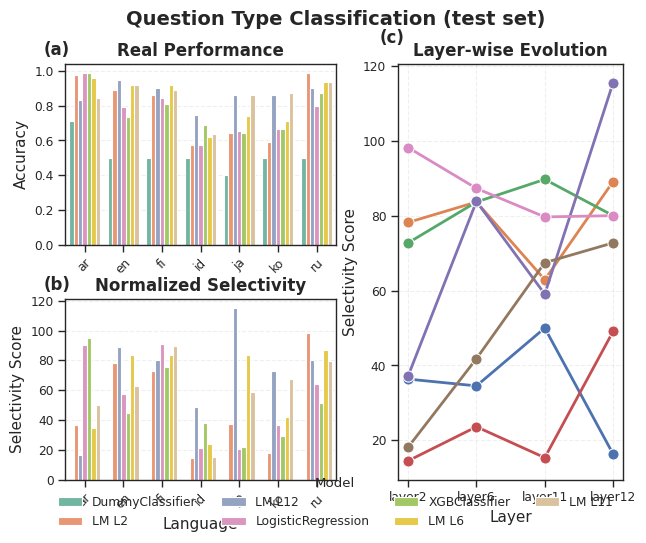

In [ ]:
fig1 = plot_task_comparison(results_df,task="question_type",split="test",submetric="overall",models=["DummyClassifier", "LogisticRegression", "XGBClassifier", "lm_probe"],normalize_selectivity=True,show_layers=True)

/tmp/ipykernel_1109400/2805205168.py:99: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.08, 1, 0.95])


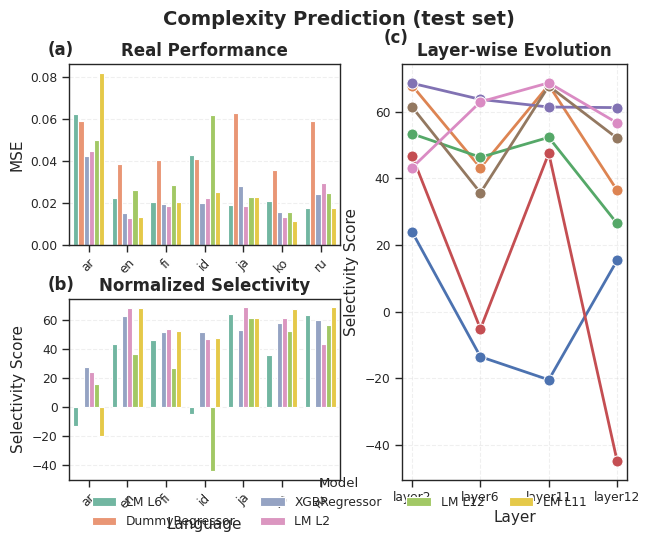

In [ ]:
fig2 = plot_task_comparison(results_df,task="complexity",split="test",submetric="complexity",models=["DummyRegressor", "RidgeRegression", "XGBRegressor", "lm_probe"],normalize_selectivity=True,show_layers=True)

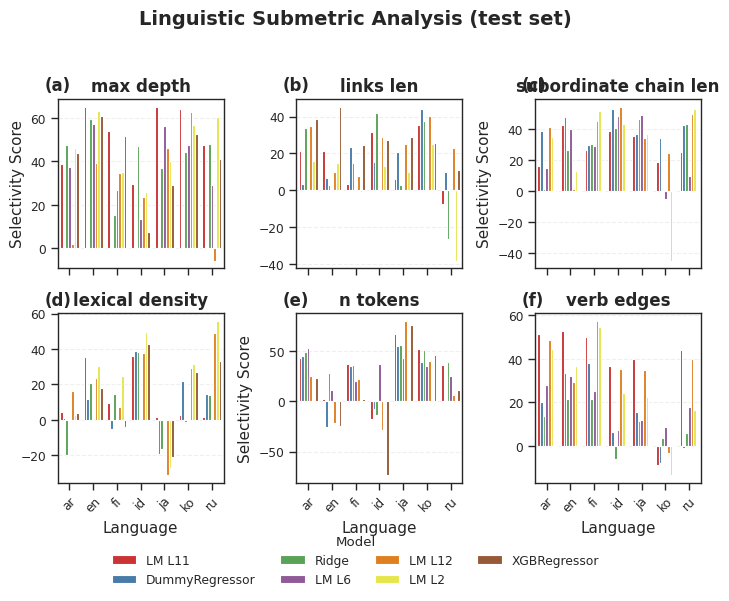

In [ ]:
fig3 = plot_submetric_grid(results_df,split="test",models=["DummyRegressor", "Ridge", "XGBRegressor", "lm_probe"],normalize_selectivity=True)

In [356]:
def create_summary_df(results_df):
    
    summary_data = []
    
    tasks = results_df["task"].unique()
    languages = results_df["language"].unique()
    
    for task in tasks:
        if task == "question_type":
            submetrics = ["overall"]
        else:
            submetrics = results_df[results_df["task"] == task]["submetric"].unique()
        
        for submetric in submetrics:
            for language in languages:
                subset = results_df[(results_df["task"] == task) & (results_df["submetric"] == submetric) &  (results_df["language"] == language) & (results_df["split"] == "test")]  
                
                if subset.empty:
                    continue
                
                #  best non-neural model
                non_neural_models = ["DummyRegressor", "DummyClassifier", "Ridge", "LogisticRegression", "XGBRegressor", "XGBClassifier"]
                non_neural_subset = subset[subset["model_type"].isin(non_neural_models)]
                
                if not non_neural_subset.empty:
                    if task == "question_type":
                        best_non_neural = non_neural_subset.loc[non_neural_subset["real"].idxmax()]
                    else:
                        best_non_neural = non_neural_subset.loc[non_neural_subset["real"].idxmin()]
                    
                    summary_data.append({
                        "task": task,
                        "submetric": submetric,
                        "language": language,
                        "model_type": "best_non_neural",
                        "specific_model": best_non_neural["model_type"],
                        "real": best_non_neural["real"],
                        "selectivity": best_non_neural["selectivity"],
                        "normalized_selectivity": best_non_neural["normalized_selectivity"]
                    })
                
                neural_subset = subset[subset["model_type"] == "lm_probe"]
                if not neural_subset.empty:
                    if task == "question_type":
                        best_neural = neural_subset.loc[neural_subset["real"].idxmax()]
                    else:
                        best_neural = neural_subset.loc[neural_subset["real"].idxmin()]
                    
                    summary_data.append({
                        "task": task,
                        "submetric": submetric,
                        "language": language,
                        "model_type": "best_neural",
                        "specific_model": f"LM Layer {best_neural['layer'].replace('layer', '')}",
                        "layer": best_neural["layer"],
                        "real": best_neural["real"],
                        "selectivity": best_neural["selectivity"],
                        "normalized_selectivity": best_neural["normalized_selectivity"]
                    })
    
    summary_df = pd.DataFrame(summary_data)
    return summary_df

summary_df = create_summary_df(results_df)

In [402]:
import matplotlib.font_manager
# List all fonts that contain "times" in the name
available_fonts = [f.name for f in matplotlib.font_manager.fontManager.ttflist if 'times' in f.name.lower()]
print("Available Times fonts:", available_fonts)

Available Times fonts: ['Times New Roman']


In [ ]:
SUBMETRIC_NAMES = {
    "avg_max_depth": "Max Depth",
    "avg_links_len": "Link Length",
    "avg_subordinate_chain_len": "Subordinate Chain Length",
    "avg_verb_edges": "Verb Edges",
    "lexical_density": "Lexical Density",
    "n_tokens": "Number of Tokens",
    "complexity": "Overall Complexity",
    "composite": "Composite Score"
}


In [ ]:
def plot_summary_comparison_improved(summary_df, task, split="test", submetric="overall"):
    import matplotlib as mpl

    mpl.rcParams['font.family'] = 'serif'
    mpl.rcParams['font.serif'] = ['Times New Roman', 'DejaVu Serif', 'serif']

    plt.rcParams.update({
        'mathtext.fontset': 'stix',
        'font.size': 11,
        'axes.titlesize': 13,
        'axes.labelsize': 11,
        'xtick.labelsize': 10,
        'ytick.labelsize': 10,
        'legend.fontsize': 9,
        'axes.linewidth': 0.8
    })

    sns.set_theme(style="ticks", context="paper", palette="colorblind", rc={"font.serif": ["Times New Roman"]})
    


    fig = plt.figure(figsize=(9, 6.0))
    gs = fig.add_gridspec(2, 2, width_ratios=[6, 1], height_ratios=[1, 1], hspace=0.3, wspace=0.02)
    ax1 = fig.add_subplot(gs[0, 0])  # Real performance
    ax2 = fig.add_subplot(gs[1, 0])  # Normalized selectivity
    ax_leg = fig.add_subplot(gs[:, 1])  
    ax_leg.axis('off')  

    data = summary_df[(summary_df["task"] == task) & (summary_df["submetric"] == submetric)].copy()

    traditional_models = ['LogisticRegression', 'Ridge', 'XGBClassifier', 'XGBRegressor']
    data['model_label'] = ''
    data['model_type'] = ''

    for model in traditional_models:
        mask = data['specific_model'].str.contains(model, case=False, na=False)
        data.loc[mask, 'model_type'] = 'traditional'
        data.loc[mask, 'model_label'] = data.loc[mask, 'specific_model'].apply(lambda x: x.split('/')[-1] if '/' in x else x)

    layer_mask = data['specific_model'].str.contains('Layer', case=False, na=False)
    data.loc[layer_mask, 'model_type'] = 'neural'
    data.loc[layer_mask, 'model_label'] = data.loc[layer_mask, 'specific_model'].apply(lambda x: f"L{x.split()[-1]}" if "Layer" in x else x)

    unique_models = data['model_label'].unique()

    colors = sns.color_palette("tab20", n_colors=len(unique_models))
    color_map = {model: colors[i % len(colors)] for i, model in enumerate(unique_models)}
    data['color'] = data['model_label'].map(color_map)

    languages = data['language'].unique()

    for lang_idx, language in enumerate(languages):
        lang_data = data[data['language'] == language]
        num_models = len(lang_data)

        bar_width = 0.8 / max(num_models, 1)

        for i, (idx, row) in enumerate(lang_data.iterrows()):
            position = lang_idx - 0.4 + (i + 0.5) * bar_width
            ax1.bar(position, row['real'], width=bar_width, color=row['color'], edgecolor='black', linewidth=0.6)

            if task == "question_type":
                value_text = f"{row['real']:.0%}"
            else:
                value_text = f"{row['real']:.3f}"

            ax1.text(position, row['real'] + 0.002, value_text, ha='center', va='bottom', fontsize=8)

    for lang_idx, language in enumerate(languages):
        lang_data = data[data['language'] == language]
        num_models = len(lang_data)

        bar_width = 0.8 / max(num_models, 1)

        for i, (idx, row) in enumerate(lang_data.iterrows()):
            position = lang_idx - 0.4 + (i + 0.5) * bar_width
            ax2.bar(position, row['normalized_selectivity'], width=bar_width, color=row['color'], edgecolor='black', linewidth=0.6)

            ax2.text(position, row['normalized_selectivity'] + 0.5, f"{row['normalized_selectivity']:.1f}", ha='center', va='bottom', fontsize=8)

    for ax in [ax1, ax2]:
        ax.set_xticks(range(len(languages)))
        ax.set_xticklabels(languages)
        ax.tick_params(axis='x', rotation=45)
        ax.grid(axis='y', linestyle='--', alpha=0.4)

    ax1.set_title("Best Model Performance", fontsize=12, fontfamily='Times New Roman', fontweight='bold')
    ax1.set_ylabel("Accuracy" if task == "question_type" else "MSE", fontfamily='Times New Roman')
    ax2.set_title("Normalized Selectivity",fontfamily='Times New Roman', fontsize=12, fontweight='bold')
    ax2.set_ylabel("Selectivity Score")
    ax2.set_xlabel("Language")

    ax1.text(-0.08, 1.05, '(a)', transform=ax1.transAxes, fontsize=12, fontweight='bold', fontfamily='Times New Roman')
    ax2.text(-0.08, 1.05, '(b)', transform=ax2.transAxes, fontsize=12, fontweight='bold', fontfamily='Times New Roman')

    legend_handles = []
    trad_models = []
    neural_models = []

    for model in unique_models:
        model_type = data[data['model_label'] == model]['model_type'].iloc[0]
        color = color_map[model]

        if model_type == 'traditional':
            trad_models.append((model, color))
        else:
            neural_models.append((model, color))

    trad_models.sort()
    neural_models.sort()

    if trad_models:
        legend_handles.append(Patch(facecolor='none', edgecolor='none', label="Traditional Models:"))
        for model, color in trad_models:
            legend_handles.append(Patch(facecolor=color, edgecolor='black', linewidth=0.6, label=f"  {model}"))

    if neural_models:
        legend_handles.append(Patch(facecolor='none', edgecolor='none', label="Neural Layers:"))
        for model, color in neural_models:
            legend_handles.append(Patch(facecolor=color, edgecolor='black', linewidth=0.6, label=f"  {model}"))

    ax_leg.legend(handles=legend_handles, loc='center', frameon=True, fontsize=9, title="Models")

    task_title = {"complexity": "Complexity Prediction","question_type": "Question Type Classification","single_submetric": SUBMETRIC_NAMES.get(submetric, submetric)}.get(task, task)

    fig.suptitle(f"{task_title} - Best Models ({split} set)", fontsize=13, fontweight='bold', y=0.98, fontfamily='Times New Roman')
    plt.tight_layout(rect=[0, 0, 0.95, 0.95])

    return fig


/tmp/ipykernel_1109400/2637110335.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.95, 0.95])


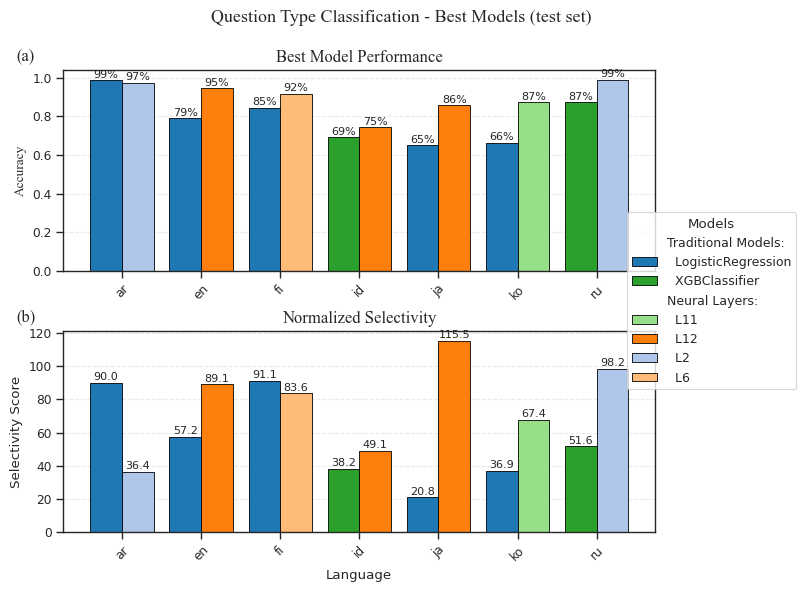

In [416]:
fig = plot_summary_comparison_improved(summary_df, task="question_type", split="test", submetric="overall")

In [383]:
def plot_summary_submetric_grid_improved(summary_df, split="test"):
    plt.rcParams.update({
        'font.family': 'serif',
        'font.serif': ['Times New Roman', 'DejaVu Serif'],
        'font.size': 11,
        'axes.titlesize': 13,
        'axes.labelsize': 11,
        'xtick.labelsize': 10,
        'ytick.labelsize': 10,
        'legend.fontsize': 9,
        'axes.linewidth': 0.8
    })
    sns.set_theme(style="ticks", context="paper", palette="colorblind")

    submetrics = ["avg_max_depth", "avg_links_len", "avg_subordinate_chain_len",
                  "lexical_density", "n_tokens", "avg_verb_edges"]

    fig = plt.figure(figsize=(12, 7))
    gs = fig.add_gridspec(2, 4, width_ratios=[1, 1, 1, 0.5], height_ratios=[1, 1], wspace=0.3, hspace=0.3)

    axes = [fig.add_subplot(gs[i//3, i%3]) for i in range(6)]
    ax_leg = fig.add_subplot(gs[:, 3])
    ax_leg.axis('off')

    # -- Prepare Data --
    all_data = summary_df[summary_df["task"] == "single_submetric"].copy()

    traditional_models = ['LogisticRegression', 'Ridge', 'XGBClassifier', 'XGBRegressor']
    all_data['model_label'] = ''
    all_data['model_type'] = ''

    for model in traditional_models:
        mask = all_data['specific_model'].str.contains(model, case=False, na=False)
        all_data.loc[mask, 'model_type'] = 'traditional'
        all_data.loc[mask, 'model_label'] = all_data.loc[mask, 'specific_model'].apply(lambda x: x.split('/')[-1] if '/' in x else x)

    layer_mask = all_data['specific_model'].str.contains('Layer', case=False, na=False)
    all_data.loc[layer_mask, 'model_type'] = 'neural'
    all_data.loc[layer_mask, 'model_label'] = all_data.loc[layer_mask, 'specific_model'].apply(lambda x: f"L{x.split()[-1]}" if "Layer" in x else x)

    unique_trad_models = sorted(all_data[all_data['model_type'] == 'traditional']['model_label'].unique())
    unique_neural_models = sorted(all_data[all_data['model_type'] == 'neural']['model_label'].unique())

    # -- Colors --
    colors = sns.color_palette("tab20", n_colors=len(unique_trad_models) + len(unique_neural_models))
    color_map = {model: colors[i] for i, model in enumerate(unique_trad_models + unique_neural_models)}
    all_data['color'] = all_data['model_label'].map(color_map)

    # -- Plotting each submetric panel --
    for i, submetric in enumerate(submetrics):
        ax = axes[i]
        data = all_data[all_data["submetric"] == submetric]

        if data.empty:
            ax.text(0.5, 0.5, f"No data for {submetric}", ha='center', va='center', transform=ax.transAxes)
            continue

        languages = sorted(data['language'].unique())

        for lang_idx, language in enumerate(languages):
            lang_data = data[data['language'] == language]
            num_models = len(lang_data)
            bar_width = 0.8 / max(num_models, 1)

            for j, (idx, row) in enumerate(lang_data.iterrows()):
                position = lang_idx - 0.4 + (j + 0.5) * bar_width
                color = row['color'] if pd.notna(row['color']) else 'gray'  # <- FIXED fallback color

                ax.bar(position, row['normalized_selectivity'], width=bar_width,
                       color=color, edgecolor='black', linewidth=0.6)

        ax.set_title(SUBMETRIC_NAMES.get(submetric, submetric), fontsize=12, fontweight='bold')
        ax.set_xticks(range(len(languages)))
        ax.set_xticklabels(languages)
        ax.tick_params(axis='x', rotation=45)
        ax.grid(axis='y', linestyle='--', alpha=0.4)

        if i % 3 == 0:
            ax.set_ylabel("Normalized Selectivity")
        else:
            ax.set_ylabel("")

        if i >= 3:
            ax.set_xlabel("Language")
        else:
            ax.set_xlabel("")

        ax.text(-0.08, 1.05, f"({chr(97+i)})", transform=ax.transAxes, fontsize=11, fontweight='bold')

    # -- Legend --
    legend_handles = []

    if unique_trad_models:
        legend_handles.append(Patch(facecolor='none', edgecolor='none', label="Traditional Models:"))
        for model in unique_trad_models:
            legend_handles.append(Patch(facecolor=color_map[model], edgecolor='black', linewidth=0.6, label=model))

    if unique_neural_models:
        legend_handles.append(Patch(facecolor='none', edgecolor='none', label="Neural Layers:"))
        for model in unique_neural_models:
            legend_handles.append(Patch(facecolor=color_map[model], edgecolor='black', linewidth=0.6, label=model))

    ax_leg.legend(handles=legend_handles, loc='center', frameon=True, fontsize=9, title="Models")

    # -- Final Layout --
    fig.suptitle("Linguistic Submetric Analysis - Best Models", fontsize=14, fontweight='bold', y=0.98)
    plt.tight_layout(rect=[0, 0, 0.90, 0.95])

    return fig


/tmp/ipykernel_1109400/2601441805.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.90, 0.95])


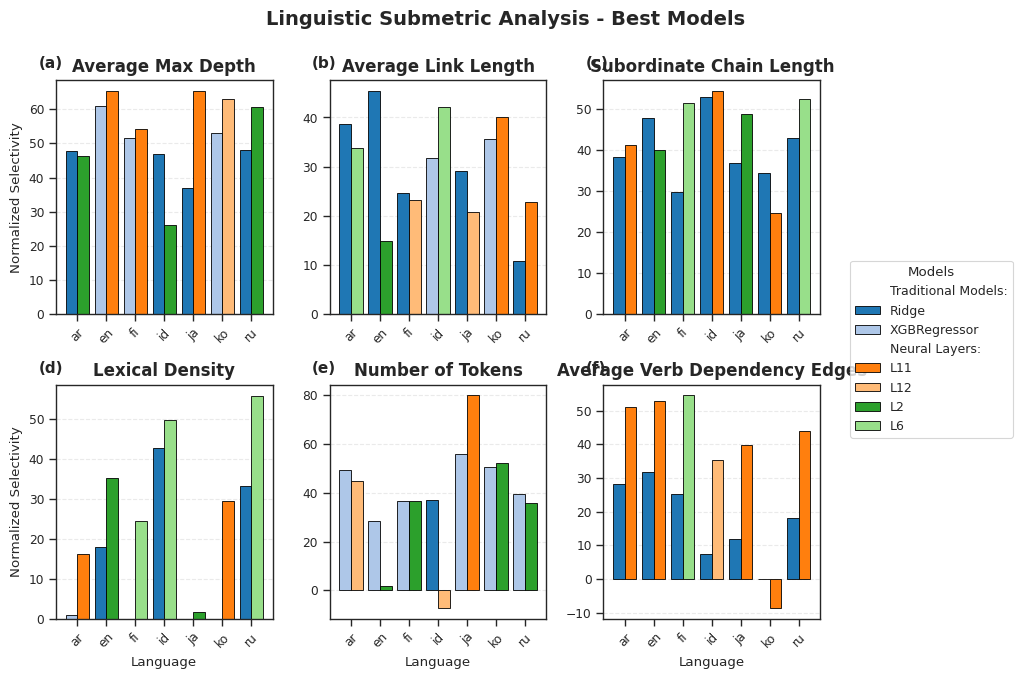

In [382]:
fig = plot_summary_submetric_grid_improved(summary_df)

In [389]:
def plot_submetric_heatmaps(df,task="single_submetric",split="test",model="lm_probe",normalize_selectivity=True,layers=["layer2", "layer6", "layer11", "layer12"],figsize=(20, 14)):

    fig, axes = plt.subplots(2, 2, figsize=figsize)
    axes = axes.flatten()

    value_col = "normalized_selectivity" if normalize_selectivity else "selectivity"

    for idx, layer in enumerate(layers):
        ax = axes[idx]

        data = df[(df["task"] == task) & (df["split"] == split) & (df["model_type"] == model) & (df["layer"] == layer)]

        if data.empty:
            ax.set_visible(False)
            continue

        pivot = data.pivot_table(index="submetric", columns="language", values=value_col)

        sns.heatmap(pivot,annot=True,fmt=".2f",cmap="YlGnBu",cbar_kws={"label": "Normalized Selectivity" if normalize_selectivity else "Selectivity"},ax=ax)

        ax.set_title(f"{layer.upper()} - {('Normalized' if normalize_selectivity else '')} Selectivity", fontsize=14)
        ax.set_xlabel("Language")
        ax.set_ylabel("Submetric")
        ax.tick_params(axis='x', rotation=45)
        ax.tick_params(axis='y', rotation=0)

    fig.suptitle(f"Submetric {'Normalized ' if normalize_selectivity else ''}Selectivity Heatmaps", fontsize=20)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


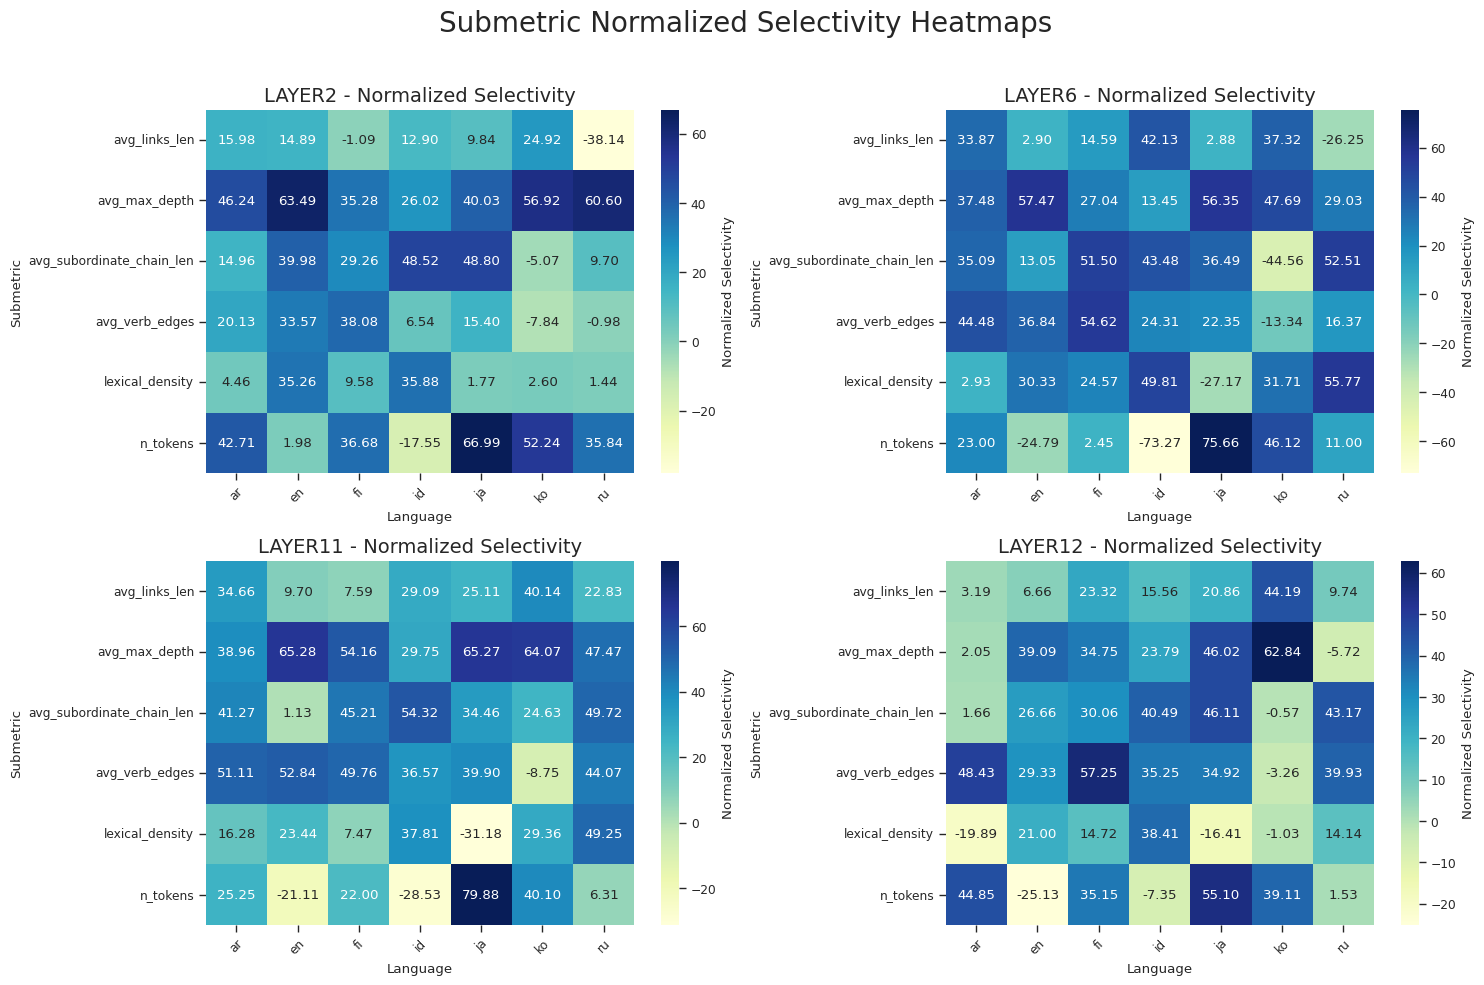

In [392]:
plot_submetric_heatmaps(results_df, normalize_selectivity=True, figsize=(15,10))